# Model
In this notebook, we will fit predictive models on our climate dataset. 

## Imports

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

## Constants

In [2]:
PROCESSED_DATA_PATH = "../data/processed"
RANDOM_STATE = 42

# 1. Pre-processing

## 1.1 Load data

In [3]:
df = pd.read_csv(os.path.join(PROCESSED_DATA_PATH, "wrangled_data.csv"))
print(f"{df.shape = }")
df.head()

df.shape = (6865, 33)


,country,year,number_of_days_min_temp_most_0_fahreheit,number_of_days_min_temp_at_most_32_fahrenheit,number_of_days_max_temp_at_most_32_fahrenheit,number_of_days_max_temp_at_most_70_fahrenheit,number_of_days_max_temp_at_least_90_fahrenheit,absolute_min_temp,max_daily_precipitation,absolute_max_temp,...,exports_percent_of_gdp,gdp_per_capita_yearly_growth,imports_percent_of_gdp,storm_affected_annual_number,population_total,cc_somw_t_per,flood_deaths_annual_number,storm_deaths_annual_number,tsunami_deaths_annual_number,extreme_temperature_affected_annual_number
0,Algeria,1950,0.0,6.333333,0.0,267.000000,100.666667,-1.200000,25.45,41.933333,...,37.252747,0.432,63.891209,0.0,8870000.0,NaN,0.0,0.0,0.0,0.0
1,Algeria,1951,0.0,3.666667,0.0,265.666667,104.000000,-0.733333,21.00,40.833333,...,37.427473,-1.300,64.212088,0.0,9020000.0,NaN,0.0,0.0,0.0,0.0
2,Algeria,1952,0.0,8.500000,0.0,254.500000,98.000000,-1.000000,8.00,44.950000,...,37.602198,2.150,64.532967,0.0,9190000.0,NaN,0.0,0.0,0.0,0.0
3,Algeria,1953,0.0,8.333333,0.0,262.666667,92.666667,-2.800000,27.55,40.666667,...,37.776923,-0.517,64.853846,0.0,9360000.0,NaN,0.0,0.0,0.0,0.0
4,Algeria,1954,0.0,4.500000,0.0,247.750000,71.500000,-1.900000,22.00,41.725000,...,37.951648,4.990,65.174725,0.0,9560000.0,NaN,0.0,0.0,0.0,0.0


## 1.2 Define semantic variable types

In [4]:
meta_variables = ["year", "country"]
environmental_variables = [
    "extreme_temperature_affected_annual_number",
    "storm_affected_annual_number",
    "storm_deaths_annual_number",
    "cc_vser_t_per",
    "flood_affected_annual_number",
    "extreme_temperature_deaths_annual_number",
    "sulfur_emissions_per_person_kg",
    "cc_vser_somw_t_per",
    "tsunami_deaths_annual_number",
    "co2_emissions_tonnes_per_person",
    "tsunami_affected_annual_number",
    "cc_somw_t_per",
    "flood_deaths_annual_number",
]
economical_variables = [
    "population_total",
    "imports_percent_of_gdp",
    "exports_percent_of_gdp",
    "gdppercapita_us_inflation_adjusted",
    "gdp_per_capita_yearly_growth",
    "inflation_annual_percent",
]
meteorological_variables = [
    "average_annual_min_temp",
    "average_annual_max_temp",
    "average_annual_temp",
    "total_precipitation",
    "absolute_max_temp",
    "max_daily_precipitation",
    "absolute_min_temp",
    "number_of_days_max_temp_at_least_90_fahrenheit",
    "number_of_days_max_temp_at_most_70_fahrenheit",
    "number_of_days_max_temp_at_most_32_fahrenheit",
    "number_of_days_min_temp_at_most_32_fahrenheit",
    "number_of_days_min_temp_most_0_fahreheit",
]

assert len(
    meta_variables
    + environmental_variables
    + economical_variables
    + meteorological_variables
) == len(df.columns.values)

## 1.3 Obtain data to explain average annual temperature

### 1.3.1 Create X, y arrays

In [5]:
y = df["average_annual_temp"]
X = df[
    ["sulfur_emissions_per_person_kg", "co2_emissions_tonnes_per_person"]
    + economical_variables
]
X = X.drop(["population_total"], axis=1)
pd.isna(X).sum()

sulfur_emissions_per_person_kg           0
co2_emissions_tonnes_per_person          0
imports_percent_of_gdp                   0
exports_percent_of_gdp                   0
gdppercapita_us_inflation_adjusted       0
gdp_per_capita_yearly_growth           347
inflation_annual_percent              2623
dtype: int64

### 1.3.2 kNN impute missing values

In [6]:
imputer = KNNImputer(n_neighbors=5)
X_imp = imputer.fit_transform(X)

### 1.3.3 Train/test-split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imp, y, test_size=0.3, random_state=RANDOM_STATE
)

data_avg_temp = {
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test,
    "feature_names": X.columns.values,
}

## 1.4 Obtain data to explain gdp per capita us inflation adjusted

### 1.4.1 Create X, y arrays

In [8]:
y = df["gdppercapita_us_inflation_adjusted"]
X = df[
    environmental_variables + meteorological_variables
]
X = X.drop(["cc_somw_t_per", "cc_vser_somw_t_per", "cc_vser_t_per"], axis=1)
pd.isna(X).sum()

extreme_temperature_affected_annual_number        0
storm_affected_annual_number                      0
storm_deaths_annual_number                        0
flood_affected_annual_number                      0
extreme_temperature_deaths_annual_number          0
sulfur_emissions_per_person_kg                    0
tsunami_deaths_annual_number                      0
co2_emissions_tonnes_per_person                   0
tsunami_affected_annual_number                    0
flood_deaths_annual_number                        0
average_annual_min_temp                           0
average_annual_max_temp                           0
average_annual_temp                               0
total_precipitation                               0
absolute_max_temp                                 0
max_daily_precipitation                           0
absolute_min_temp                                 0
number_of_days_max_temp_at_least_90_fahrenheit    0
number_of_days_max_temp_at_most_70_fahrenheit     0
number_of_da

### 1.4.2 kNN impute missing values

In [9]:
imputer = KNNImputer(n_neighbors=5)
X_imp = imputer.fit_transform(X)

### 1.4.3 Train/test-split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imp, y, test_size=0.3, random_state=RANDOM_STATE
)

data_gdp = {
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test,
    "feature_names": X.columns.values,
}

## 1.5 Obtain data to explain co2 emissions tonnes per person

### 1.5.1 Create X, y arrays

In [11]:
y = df["co2_emissions_tonnes_per_person"]
X = df[
    economical_variables + meteorological_variables
]
pd.isna(X).sum()

population_total                                     0
imports_percent_of_gdp                               0
exports_percent_of_gdp                               0
gdppercapita_us_inflation_adjusted                   0
gdp_per_capita_yearly_growth                       347
inflation_annual_percent                          2623
average_annual_min_temp                              0
average_annual_max_temp                              0
average_annual_temp                                  0
total_precipitation                                  0
absolute_max_temp                                    0
max_daily_precipitation                              0
absolute_min_temp                                    0
number_of_days_max_temp_at_least_90_fahrenheit       0
number_of_days_max_temp_at_most_70_fahrenheit        0
number_of_days_max_temp_at_most_32_fahrenheit        0
number_of_days_min_temp_at_most_32_fahrenheit        0
number_of_days_min_temp_most_0_fahreheit             0
dtype: int

### 1.5.2 kNN impute missing values

In [12]:
imputer = KNNImputer(n_neighbors=5)
X_imp = imputer.fit_transform(X)

### 1.5.3 Train/test-split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X_imp, y, test_size=0.3, random_state=RANDOM_STATE
)

data_co2 = {
    "X_train": X_train,
    "X_test": X_test,
    "y_train": y_train,
    "y_test": y_test,
    "feature_names": X.columns.values,
}

# 2. Modeling

## 2.1 Fit models to explain average annual temperature

In [14]:
models_avg_temp = {}

### 2.1.1 Linear model

In [15]:
def fit_lm(data_dict):
    lm = make_pipeline(StandardScaler(), LinearRegression())
    lm.fit(data_dict["X_train"], data_dict["y_train"])
    return lm


models_avg_temp["lm"] = fit_lm(data_avg_temp)

### 2.1.2 Ridge regression

In [16]:
def fit_ridge(data_dict):
    ridge = make_pipeline(StandardScaler(), RidgeCV())
    ridge.fit(data_dict["X_train"], data_dict["y_train"])
    return ridge


models_avg_temp["ridge"] = fit_ridge(data_avg_temp)

### 2.1.3 Lasso regression

In [17]:
def fit_lasso(data_dict):
    lasso = make_pipeline(StandardScaler(), LassoCV(random_state=RANDOM_STATE))
    lasso.fit(data_dict["X_train"], data_dict["y_train"])
    return lasso


models_avg_temp["lasso"] = fit_lasso(data_avg_temp)

### 2.1.4 Random forest regression

In [18]:
def fit_rf(data_dict):
    rf = RandomForestRegressor(
        min_samples_split=10, min_samples_leaf=10, random_state=RANDOM_STATE, n_jobs=-1
    )
    rf.fit(data_dict["X_train"], data_dict["y_train"])
    return rf


models_avg_temp["rf"] = fit_rf(data_avg_temp)

## 2.2 Fit models to explain gdp per capita us inflation adjusted

In [19]:
models_gdp = {}

### 2.2.1 Linear model

In [20]:
models_gdp["lm"] = fit_lm(data_gdp)

### 2.2.2 Ridge regression

In [21]:
models_gdp["ridge"] = fit_ridge(data_gdp)

### 2.1.3 Lasso regression

In [22]:
models_gdp["lasso"] = fit_lasso(data_gdp)

### 2.1.4 Random forest regression

In [23]:
models_gdp["rf"] = fit_rf(data_gdp)

## 2.3 Fit models to explain co2 emissions tonnes per person 

In [24]:
models_co2 = {}

### 2.2.1 Linear model

In [25]:
models_co2["lm"] = fit_lm(data_co2)

### 2.2.2 Ridge regression

In [26]:
models_co2["ridge"] = fit_ridge(data_co2)

### 2.1.3 Lasso regression

In [27]:
models_co2["lasso"] = fit_lasso(data_co2)

### 2.1.4 Random forest regression

In [28]:
models_co2["rf"] = fit_rf(data_co2)

# 3. Evaluation

## 3.1 Model explaining average annual temperature

### 3.1.1 Prediction quality

In [29]:
def predict(model_dict, data_dict):
    preds_train = {}
    preds_test = {}
    for model_name in model_dict:
        # predict
        preds_train[model_name] = model_dict[model_name].predict(data_dict["X_train"])
        preds_test[model_name] = model_dict[model_name].predict(data_dict["X_test"])

    return preds_train, preds_test


def root_mean_squared_error(y, y_hat):
    return np.sqrt(np.mean((y - y_hat) ** 2))


def evaluate_models(preds_train, preds_test, data_dict):
    eval_holder = []

    for model_name in preds_train:
        # RMSE
        rmse_train = root_mean_squared_error(
            data_dict["y_train"], preds_train[model_name]
        )
        rmse_test = root_mean_squared_error(data_dict["y_test"], preds_test[model_name])

        # MAE
        mae_train = mean_absolute_error(data_dict["y_train"], preds_train[model_name])
        mae_test = mean_absolute_error(data_dict["y_test"], preds_test[model_name])

        # append metrics
        eval_holder.append(
            {
                "model": model_name,
                "split": "train",
                "RMSE": rmse_train,
                "MAE": mae_train,
            }
        )
        eval_holder.append(
            {"model": model_name, "split": "test", "RMSE": rmse_test, "MAE": mae_test}
        )
    return pd.DataFrame(eval_holder)


preds_avg_temp = predict(models_avg_temp, data_avg_temp)
eval_avg_temp = evaluate_models(preds_avg_temp[0], preds_avg_temp[1], data_avg_temp)
eval_avg_temp

,model,split,RMSE,MAE
0,lm,train,7.776243,6.571000
1,lm,test,7.787621,6.619624
2,ridge,train,7.776246,6.571473
3,ridge,test,7.787845,6.620295
4,lasso,train,7.779240,6.583474
5,lasso,test,7.794213,6.635184
6,rf,train,3.335065,2.361661
7,rf,test,4.043730,2.903122


#### 3.1.1.1 Visualize metrics

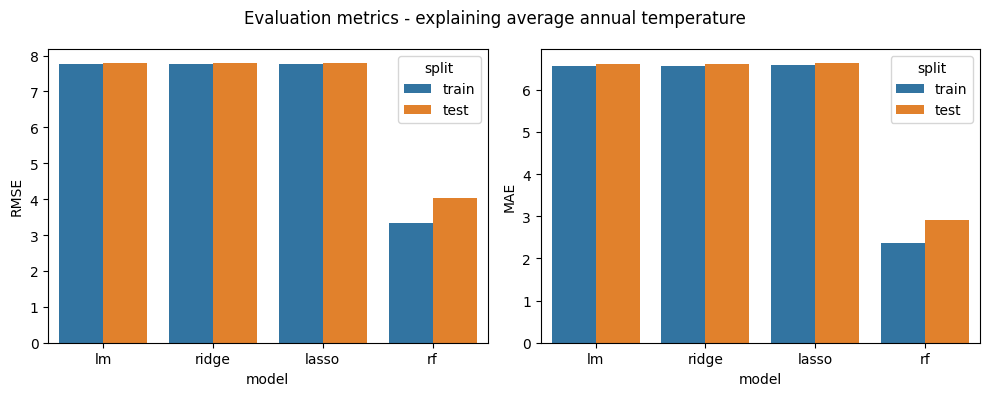

In [30]:
def viz_metrics(eval_df, title=""):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle(f"Evaluation metrics {title}")
    axs = axs.flatten()
    sns.barplot(x="model", y="RMSE", hue="split", data=eval_df, ax=axs[0])
    sns.barplot(x="model", y="MAE", hue="split", data=eval_df, ax=axs[1])
    
    fig.tight_layout()
viz_metrics(eval_avg_temp, "- explaining average annual temperature")

#### 3.1.1.2 Visualize predicted vs. actual values

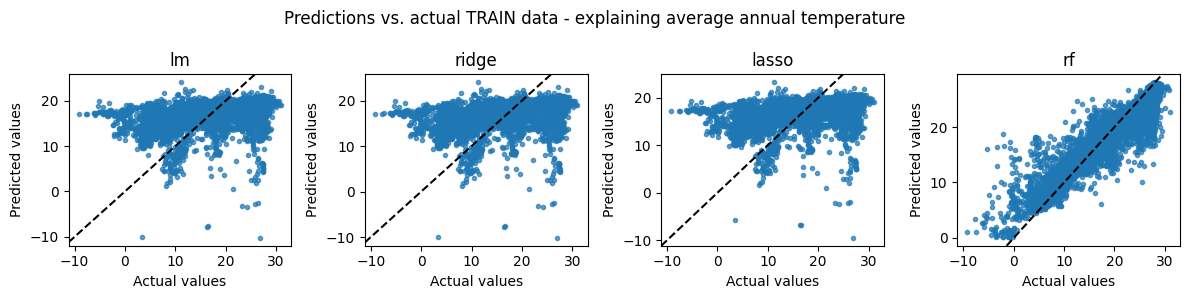

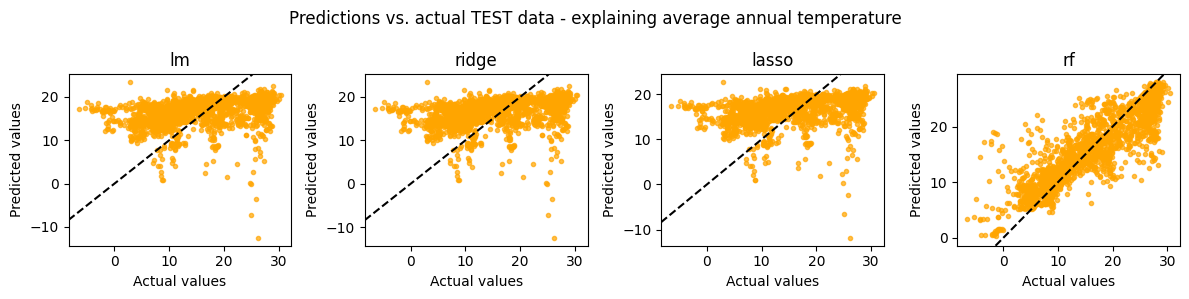

In [31]:
def viz_predicted_actual(preds_train, preds_test, data_dict, title=""):
    fig1, axs1 = plt.subplots(1, 4, figsize=(12, 3))
    fig1.suptitle(f"Predictions vs. actual TRAIN data {title}")
    axs1 = axs1.flatten()

    fig2, axs2 = plt.subplots(1, 4, figsize=(12, 3))
    fig2.suptitle(f"Predictions vs. actual TEST data {title}")
    axs2 = axs2.flatten()

    for i, model_name in enumerate(preds_train):
        # train
        axs1[i].scatter(
            data_dict["y_train"], preds_train[model_name], marker=".", alpha=0.7
        )
        axs1[i].set_title(model_name)
        axs1[i].axline((0, 0), slope=1, color="black", linestyle="dashed")
        axs1[i].set_xlabel("Actual values")
        axs1[i].set_ylabel("Predicted values")

        # test
        axs2[i].scatter(
            data_dict["y_test"],
            preds_test[model_name],
            marker=".",
            alpha=0.7,
            color="orange",
        )
        axs2[i].set_title(model_name)
        axs2[i].axline((0, 0), slope=1, color="black", linestyle="dashed")
        axs2[i].set_xlabel("Actual values")
        axs2[i].set_ylabel("Predicted values")

    fig1.tight_layout()
    fig2.tight_layout()


viz_predicted_actual(
    preds_avg_temp[0],
    preds_avg_temp[1],
    data_avg_temp,
    "- explaining average annual temperature",
)

### 3.1.2 Feature influence

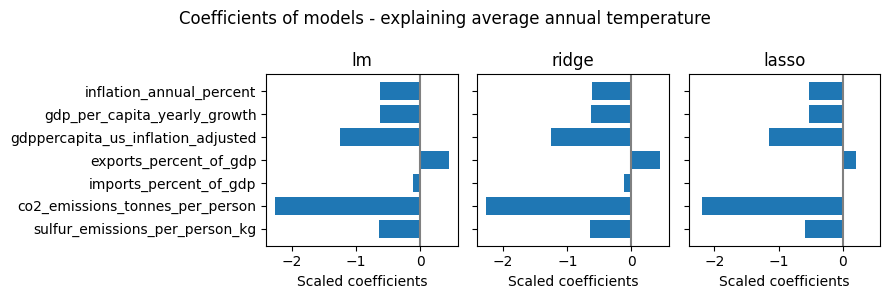

In [32]:
def viz_coefs(model_dict, feature_names, title="", height=3):
    fig, axs = plt.subplots(1, 3, figsize=(9, height), sharey=True, sharex=True)
    fig.suptitle(f"Coefficients of models {title}")
    for i, model_name in enumerate(model_dict):
        if model_name != "rf":
            axs[i].barh(feature_names, model_dict[model_name]._final_estimator.coef_)
            axs[i].axvline(x=0, color=".5")
            axs[i].set_title(model_name)
            axs[i].set_xlabel("Scaled coefficients")
    fig.tight_layout()
            
viz_coefs(models_avg_temp, data_avg_temp["feature_names"], "- explaining average annual temperature")

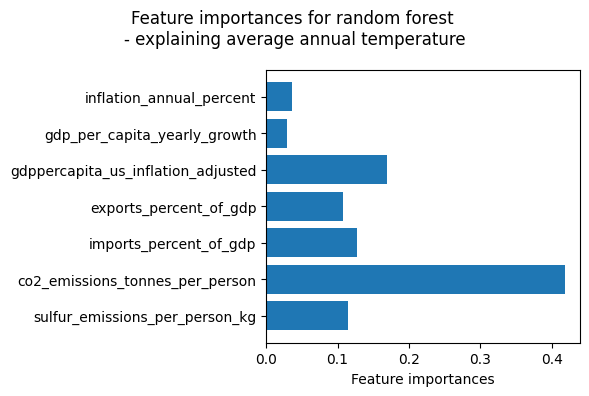

In [33]:
def viz_feature_importance(rf, feature_names, title="", height=4):
    fig, ax = plt.subplots(figsize=(6, height))
    fig.suptitle(f"Feature importances for random forest \n{title}")
    ax.barh(feature_names, rf.feature_importances_)
    ax.set_xlabel("Feature importances")
    fig.tight_layout()

viz_feature_importance(models_avg_temp["rf"], data_avg_temp["feature_names"], "- explaining average annual temperature")

## 3.2 Model explaining gdp per capita us inflation adjusted

### 3.2.1 Prediction quality

In [34]:
preds_gdp = predict(models_gdp, data_gdp)
eval_gdp = evaluate_models(preds_gdp[0], preds_gdp[1], data_gdp)
eval_gdp

,model,split,RMSE,MAE
0,lm,train,15210.334314,9783.325455
1,lm,test,15598.894354,10072.393941
2,ridge,train,15211.866223,9770.874203
3,ridge,test,15619.289839,10077.263350
4,lasso,train,15263.249608,9775.053916
5,lasso,test,15605.666757,10086.617338
6,rf,train,7200.114689,3704.981094
7,rf,test,8419.814399,4746.999382


#### 3.2.1.1 Visualize metrics

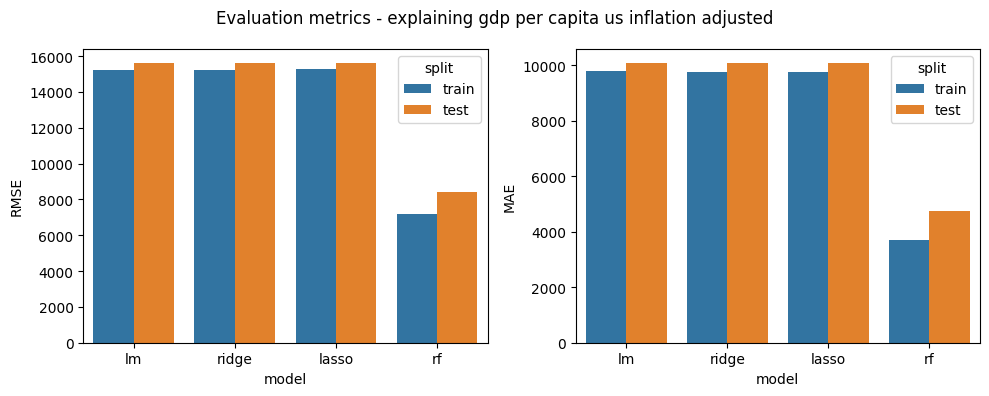

In [35]:
viz_metrics(eval_gdp, "- explaining gdp per capita us inflation adjusted")

#### 3.2.1.2 Visualize predicted vs. actual values

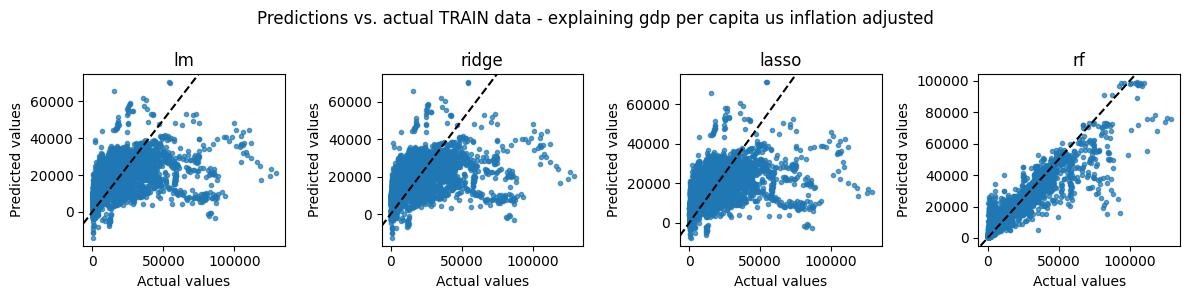

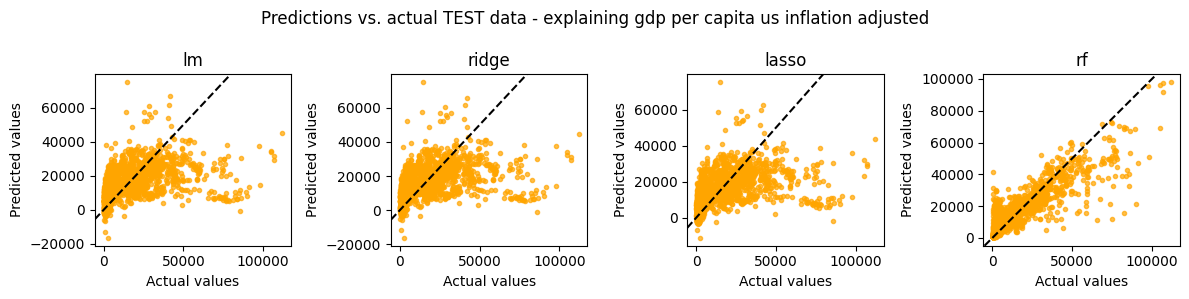

In [36]:
viz_predicted_actual(
    preds_gdp[0],
    preds_gdp[1],
    data_gdp,
    "- explaining gdp per capita us inflation adjusted",
)

### 3.2.2 Feature influence

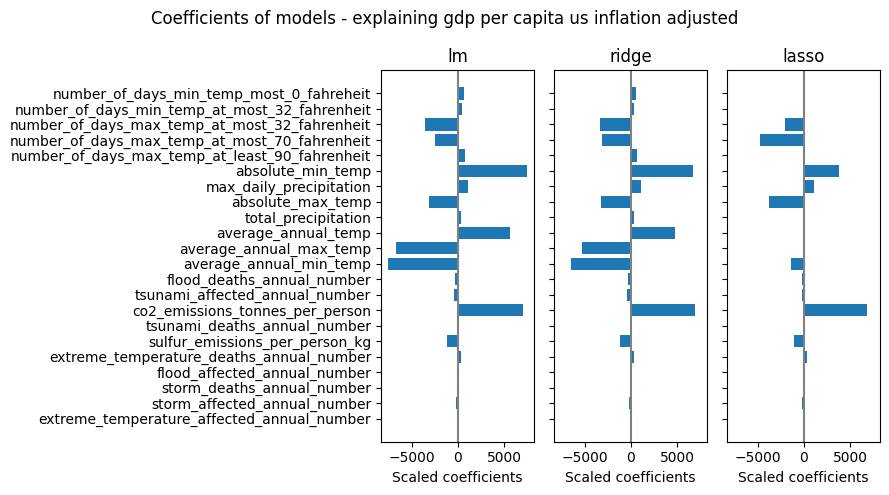

In [37]:
viz_coefs(models_gdp, data_gdp["feature_names"], "- explaining gdp per capita us inflation adjusted", 5)

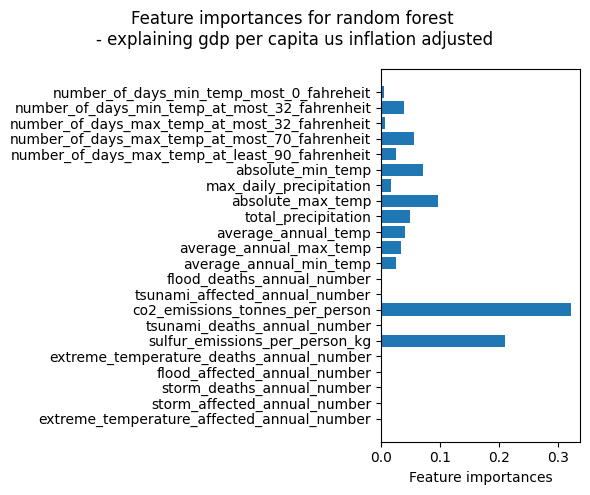

In [38]:
viz_feature_importance(models_gdp["rf"], data_gdp["feature_names"], "- explaining gdp per capita us inflation adjusted", 5)

## 3.3 Model explaining co2 emissions tonnes per person

### 3.3.1 Prediction quality

In [39]:
preds_co2 = predict(models_co2, data_co2)
eval_co2 = evaluate_models(preds_co2[0], preds_co2[1], data_co2)
eval_co2

,model,split,RMSE,MAE
0,lm,train,4.766357,3.123264
1,lm,test,4.759960,3.102033
2,ridge,train,4.766391,3.121222
3,ridge,test,4.760088,3.099913
4,lasso,train,4.766754,3.116149
5,lasso,test,4.760568,3.094450
6,rf,train,1.733894,0.842793
7,rf,test,2.072809,1.061809


#### 3.3.1.1 Visualize metrics

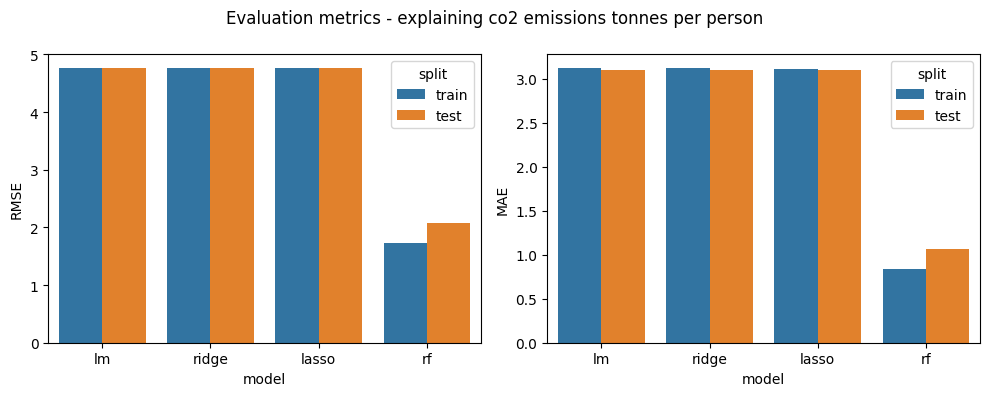

In [40]:
viz_metrics(eval_co2, "- explaining co2 emissions tonnes per person")

#### 3.3.1.2 Visualize predicted vs. actual values

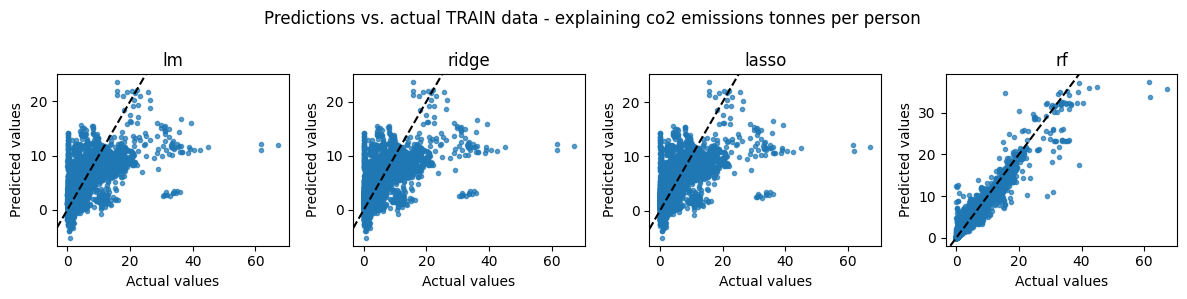

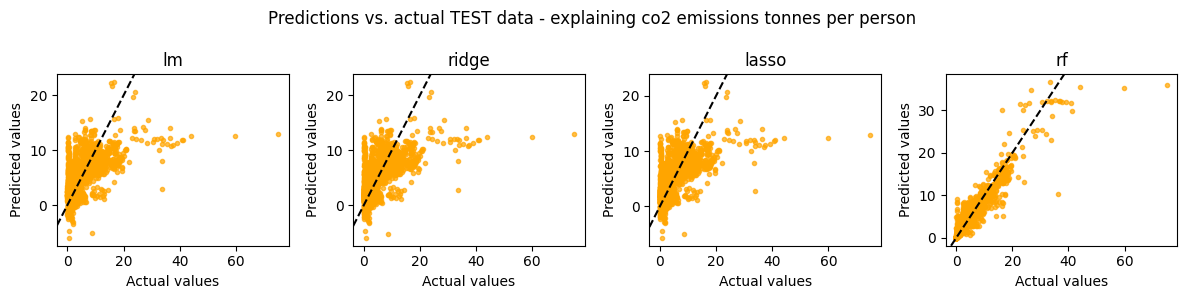

In [41]:
viz_predicted_actual(
    preds_co2[0],
    preds_co2[1],
    data_co2,
    "- explaining co2 emissions tonnes per person",
)

### 3.3.2 Feature influence

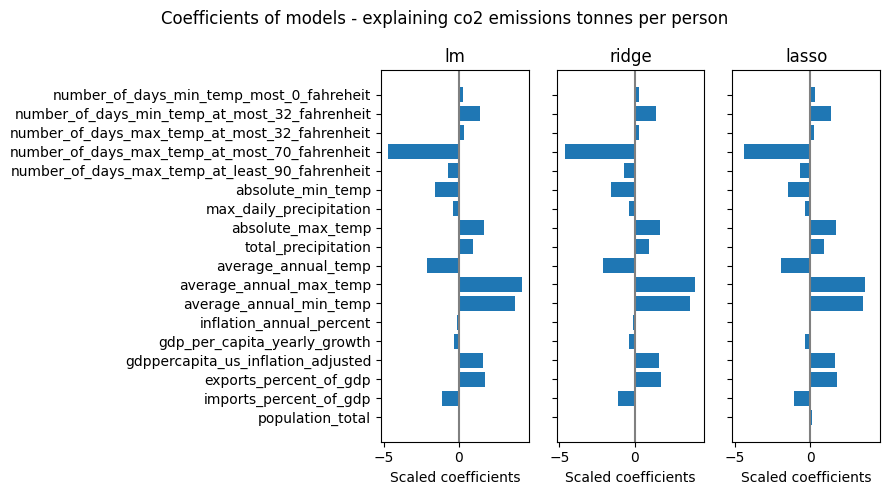

In [42]:
viz_coefs(models_co2, data_co2["feature_names"], "- explaining co2 emissions tonnes per person", 5)

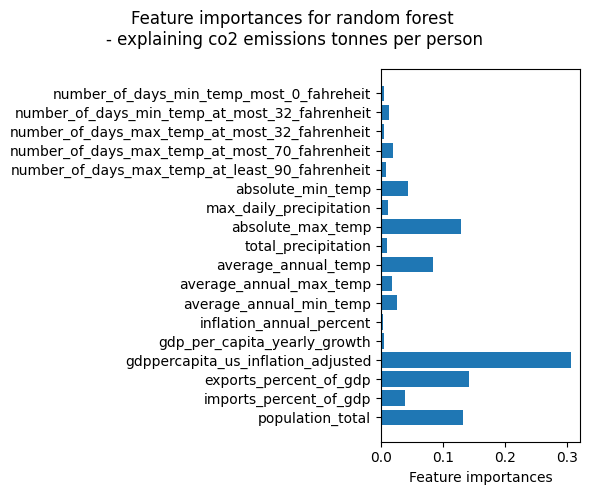

In [43]:
viz_feature_importance(models_co2["rf"], data_co2["feature_names"], "- explaining co2 emissions tonnes per person", 5)